In [45]:
noise_level=0.15

In [46]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *
import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)
     

x = np.linspace(0,1,2**8)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)
 
 
# Generate a sample signal 
signal = bumps(x) + np.random.normal(0,noise_level ,x.shape)
 
# Perform wavelet decomposition
wavelet = pywt.Wavelet('db3')

In [47]:
pywt.swt  (signal, wavelet, level=7 , trim_approx=True)

[array([3.69710991, 3.63505936, 3.57480302, 3.51661557, 3.46196871,
        3.41222199, 3.36741654, 3.32480014, 3.28386091, 3.24611056,
        3.2114117 , 3.1769144 , 3.14317169, 3.11035798, 3.07742112,
        3.04815958, 3.02163442, 2.99178249, 2.96026325, 2.92946102,
        2.89973154, 2.87339154, 2.851079  , 2.83092449, 2.80969828,
        2.78487009, 2.75784228, 2.73111855, 2.70474452, 2.67884446,
        2.6529307 , 2.62270958, 2.59261912, 2.568783  , 2.54851927,
        2.5273191 , 2.50154132, 2.46849861, 2.43001204, 2.39176486,
        2.35405497, 2.31466453, 2.27112589, 2.22523288, 2.17952933,
        2.13353415, 2.08890469, 2.04322152, 1.99407316, 1.94638218,
        1.89920803, 1.85301817, 1.8102902 , 1.77051245, 1.73246872,
        1.69510532, 1.6597477 , 1.62891175, 1.60445787, 1.58453028,
        1.56636773, 1.55094624, 1.54106992, 1.53891299, 1.54165274,
        1.54260157, 1.5407314 , 1.53688634, 1.53109501, 1.5228078 ,
        1.50918367, 1.49103051, 1.47103996, 1.45

In [48]:
import pywt
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
import matplotlib.pyplot as plt

# Translation-Invariant Wavelet Decomposition
def translation_invariant_wavelet(signal, wavelet, level):
    """
    Perform translation-invariant wavelet decomposition using SWT.

    Parameters
    ----------
    signal : ndarray
        Input signal for wavelet decomposition.
    wavelet : str
        Wavelet name (e.g., 'db1', 'haar', etc.).
    level : int
        Decomposition level.

    Returns
    -------
    list of tuples
        Each tuple contains (approximation, detail) coefficients at each level.
    """
    coeffs = pywt.swt(signal, wavelet, level=level, trim_approx=False)
    return coeffs


# Build Dyadic Graph for SWT Coefficients
def build_swt_graph(coeffs, noise_level):
    """
    Build a graph using translation-invariant wavelet coefficients.

    Parameters
    ----------
    coeffs : list of tuples
        SWT coefficients [(cAn, cDn), ..., (cA2, cD2), (cA1, cD1)].
    noise_level : float
        Noise level to include as a feature.

    Returns
    -------
    Data : torch_geometric.data.Data
        PyTorch Geometric graph object.
    """
    node_features = []  # Node features (coeff, noise_level)
    edges = []  # Graph edges
    current_node = 0  # Node index tracker
    prev_approx_nodes = []  # Track nodes of approximation coefficients from the previous level

    # Add nodes and edges
    for level, (approx, detail) in enumerate(coeffs):
        current_approx_nodes = []
        current_detail_nodes = []

        # Add approximation and detail coefficients as nodes
        for i in range(len(approx)):
            # Approximation node
            node_features.append([approx[i], noise_level])
            current_approx_nodes.append(current_node)
            current_node += 1

            # Detail node
            node_features.append([detail[i], noise_level])
            current_detail_nodes.append(current_node)
            current_node += 1

        # Add edges within the current level
        for a_node, d_node in zip(current_approx_nodes, current_detail_nodes):
            edges.append([a_node, d_node])  # Connect approximation to detail

        # Add edges between levels (parent-child relationship)
        for prev_a_node in prev_approx_nodes:
            for a_node in current_approx_nodes:
                edges.append([prev_a_node, a_node])  # Connect previous approx to current approx

        prev_approx_nodes = current_approx_nodes  # Update for the next level

    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)


# Translation-Invariant Wavelet Transform
wavelet = 'db10'
level = 8
coeffs_ti = translation_invariant_wavelet(signal, wavelet, level)

# Build the graph
noise_level = 0.2
wavelet_graph_ti = build_swt_graph(coeffs_ti, noise_level)

Data(x=[4096, 2], edge_index=[2, 460800])

C:\Users\WD\AppData\Local\Temp\ipykernel_6236\516045842.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(wavelet_graph_ti.edge_index, dtype=torch.long).t().contiguous()


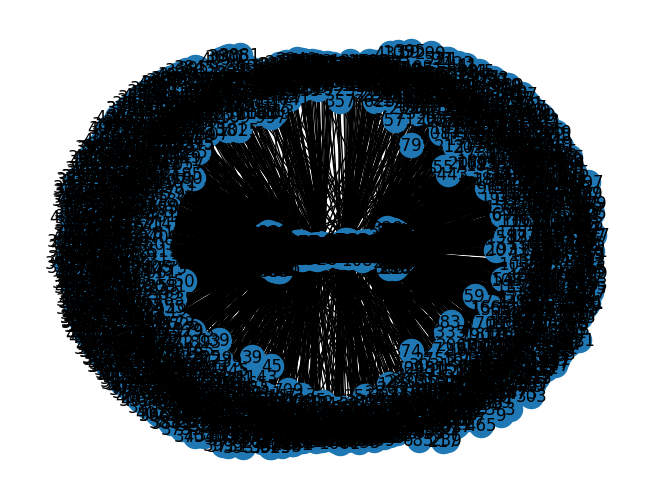

In [66]:
edge_index = torch.tensor(wavelet_graph_ti.edge_index, dtype=torch.long).t().contiguous()
import networkx as nx

def visualize_graph(data):
    G = nx.Graph()
    edge_list = data.edge_index.t().numpy()
    for edge in edge_list:
        G.add_edge(edge[0], edge[1])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=300)
    plt.show()

visualize_graph(wavelet_graph_ti)


In [ ]:
for level, (cA, cD) in enumerate(coeffs_ti):
    plt.figure()
    plt.plot(cA, label=f'Approximation Level {level+1}')
    plt.plot(cD, label=f'Detail Level {level+1}')
    plt.legend()
    plt.show()


In [67]:
wavelet_graph_ti.edge_attr

In [68]:
wavelet_graph_ti

Data(x=[4096, 2], edge_index=[2, 460800])

In [69]:
coeffs_ti

[(array([4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4.08609091, 4.08609091, 4.08609091,
         4.08609091, 4.08609091, 4

In [70]:
num_classes = 20
betahat=np.concatenate( coeffs_ti)
sebetahat= np.full_like(np.concatenate( coeffs_ti) , noise_level ) 
scale = autoselect_scales_mix_norm(betahat ,
                                   sebetahat , 
                                       max_class=num_classes ) 

num_classes= scale.shape[0]
print( (scale) )
print(scale.shape)

[ 0.          0.59917795  1.19835589  1.79753384  2.39671179  2.99588974
  3.59506768  4.19424563  4.79342358  5.39260152  5.99177947  6.59095742
  7.19013536  7.78931331  8.38849126  8.98766921  9.58684715 10.1860251
 10.78520305 11.38438099]
(20,)


In [71]:
# Build the graph
noise_level = 0.2
wavelet_graph_ti = build_swt_graph(coeffs_ti, noise_level)

In [72]:
 


# Define the GNN model
class SimpleGNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Graph convolution layers with ReLU activation
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.relu(self.conv3(x, edge_index))

        # Fully connected layer and softmax
        x = self.fc(x)
        x = self.softmax(x)
        return x


# Custom loss function
def custom_loss(pred_pi, marginal_log_lik, penalty=10.1, epsilon=1e-10):
    """
    Compute the penalized log likelihood function using vectorized operations.

    Parameters:
    pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
    marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
    penalty (float): The penalty term.
    epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
    torch.Tensor: The negative penalized log likelihood (for minimization purposes).
    """
    # Compute L_batch as the exponentiated marginal_log_lik (this is vectorized across all rows)
    L_batch = torch.exp(marginal_log_lik)

    # Element-wise multiplication between pred_pi and L_batch, sum over the components (columns)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)
    # Ensure inner_sum is not too small to avoid log(0) or log(negative)
    inner_sum = torch.clamp(inner_sum, min=epsilon)

    # Compute the first sum: sum of log(inner_sum) across the minibatch (batch_size)
    first_sum = torch.sum(torch.log(inner_sum))

    # Penalty term: based on the first component of pred_pi (penalty on pred_pi[:, 0])
    if penalty > 1:
        pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
        penalized_log_likelihood_value = first_sum + (penalty - 1) * torch.log(pi_clamped)
    else:
        penalized_log_likelihood_value = first_sum

    # Return the negative of the penalized log-likelihood
    return -penalized_log_likelihood_value

# Prepare data
betahat_ti = np.concatenate([np.concatenate(c) for c in coeffs_ti])  # Flatten coefficients
sebetahat_ti = np.full_like(betahat_ti, 0.2)  # Constant noise level

# Compute marginal log-likelihood
fit_como_data_loglik_ti = get_data_loglik_normal(
    betahat=betahat_ti,
    sebetahat=sebetahat_ti,
    location=np.zeros(scale.shape),
    scale=scale,
)
y_train_ti = torch.FloatTensor(fit_como_data_loglik_ti)

# Initialize model
input_size = 2
hidden_size = 64
num_classes = len(scale)
model = SimpleGNN(input_size, hidden_size, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 300
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(wavelet_graph_ti)
    loss = custom_loss(predictions, y_train_ti)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions_ti = model(wavelet_graph_ti)

# Convert predictions to numpy array
predictions_array_ti = predictions_ti.detach().cpu().numpy()
print(predictions_array_ti.shape)


Epoch 1, Loss: 9487.869140625
Epoch 101, Loss: 6940.2626953125
Epoch 201, Loss: 6833.93798828125
(4096, 20)


In [55]:
# Flatten the SWT coefficients
n_samples = len(betahat_ti)  # Total number of coefficients
est_post_ti = np.zeros(n_samples)

# Compute posterior mean for each sample
for i in range(n_samples):
    est_post_ti[i] = posterior_mean_norm(
        betahat=np.array([betahat_ti[i]]),
        sebetahat=np.array([sebetahat_ti[i]]),
        log_pi=np.log(predictions_array_ti[i, :]),
        scale=scale  # Assuming this is available from earlier in your code
    ).post_mean

# Reshape the posterior mean into the structure of the SWT coefficients
est_post_ti_structured = []
start_idx = 0

for level, (approx, detail) in enumerate(coeffs_ti):
    n_coeffs = len(approx)
    # Extract the corresponding posterior means
    approx_post = est_post_ti[start_idx:start_idx + n_coeffs]
    detail_post = est_post_ti[start_idx + n_coeffs:start_idx + 2 * n_coeffs]
    start_idx += 2 * n_coeffs

    # Append to structured list
    est_post_ti_structured.append((approx_post, detail_post))

# est_post_ti_structured now matches the structure of coeffs_ti


C:\Users\WD\AppData\Local\Temp\ipykernel_6236\169061923.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post_ti[i] = posterior_mean_norm(
C:\Users\WD\AppData\Local\Temp\ipykernel_6236\169061923.py:10: RuntimeWarning: divide by zero encountered in log
  log_pi=np.log(predictions_array_ti[i, :]),


In [56]:
res_ash = ash(betahat_ti, sebetahat_ti)

In [57]:
coeffs_ti_true=pywt.swt (doppler (x), wavelet, level)

In [58]:
coeffs_ti_true = np.concatenate([np.concatenate(c) for c in coeffs_ti_true])  

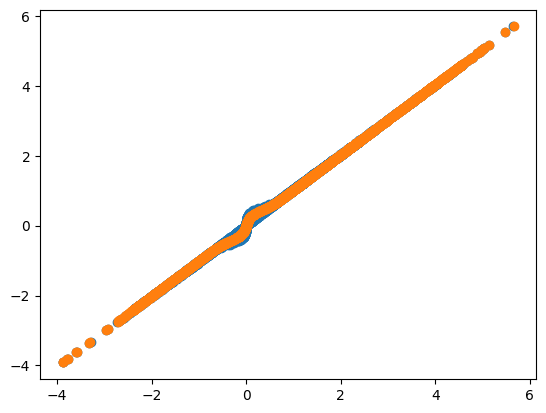

In [59]:
plt.scatter(est_post_ti ,betahat_ti)
plt.scatter(res_ash.post_mean ,betahat_ti)


In [60]:
coeffs_ti_true

array([ 1.65968241,  1.66441312,  1.66843682, ..., -0.03133673,
       -0.01945395,  0.10078247], shape=(3584,))

In [61]:
est_post_ti

array([ 4.0578341 ,  4.05783413,  4.0578341 , ...,  0.00608616,
       -0.01392662,  0.14560019], shape=(4096,))

In [62]:
est_post_ti_structured_ash = []
start_idx = 0

for level, (approx, detail) in enumerate(coeffs_ti):
    n_coeffs = len(approx)
    # Extract the corresponding posterior means
    approx_post = res_ash.post_mean[start_idx:start_idx + n_coeffs]
    detail_post = res_ash.post_mean[start_idx + n_coeffs:start_idx + 2 * n_coeffs]
    start_idx += 2 * n_coeffs

    # Append to structured list
    est_post_ti_structured_ash.append((approx_post, detail_post))

In [63]:

reconstructed_signal_gnn = pywt.iswt(est_post_ti_structured, wavelet)
reconstructed_signal_ash = pywt.iswt(est_post_ti_structured_ash, wavelet)

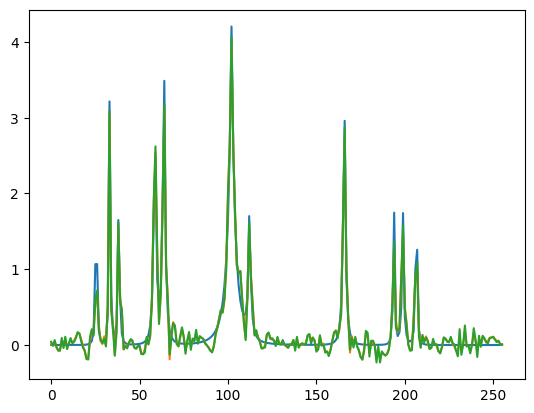

In [64]:
plt.plot(bumps(x))
plt.plot(reconstructed_signal_gnn)
plt.plot(reconstructed_signal_ash)


In [42]:
mse_ash = np.mean((reconstructed_signal_ash- bumps(x))**2)
mse_gnn_ash = np.mean((reconstructed_signal_gnn- bumps(x))**2)
print(f"MSE (Ash Post vs True): {mse_ash:.4f}")
print(f"MSE (Gnn ash Est  vs   True): {mse_gnn_ash:.4f}")

MSE (Ash Post vs True): 0.0010
MSE (Gnn ash Est  vs   True): 0.0017
